## Import and clean data  

In [2]:
from util.clean_data import clean_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

df = pd.read_csv('data/diamond.csv')

# performs interger encoding and log transforms carat and price.
df = clean_data(df)

Y_price = df['price'].values

df = df.drop(["carat", "price"], axis=1)

df = (df - df.mean() ) / df.std(ddof=1)


df.describe()

,cut,color,clarity,depth,table,x,z,y,log_carat,log_price
count,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04
mean,6.744492e-17,-1.517511e-16,2.529184e-16,5.930147e-15,3.266863e-15,-5.058369e-16,4.215307e-16,-3.372246e-17,-1.348898e-16,7.250329e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.600840e+00,-2.002112e+00,-1.852318e+00,-1.308748e+01,-6.470013e+00,-5.109073e+00,-5.014510e+00,-5.020884e+00,-2.076631e+00,-1.970997e+00
25%,-8.096876e-01,-8.264057e-01,-6.380891e-01,-5.231005e-01,-6.521325e-01,-9.103164e-01,-8.909378e-01,-8.882717e-01,-8.914146e-01,-9.168749e-01
50%,8.588829e-02,-2.385525e-01,-3.097476e-02,3.531645e-02,-2.046032e-01,-2.777527e-02,-1.237607e-02,-2.147379e-02,6.547575e-02,-3.082723e-03
75%,9.814642e-01,9.371541e-01,5.761396e-01,5.239313e-01,6.904554e-01,7.210475e-01,7.103118e-01,7.052356e-01,7.424201e-01,7.818057e-01
max,9.814642e-01,1.525007e+00,2.397483e+00,1.204128e+01,1.680151e+01,4.465161e+00,4.004720e+01,4.654922e+01,3.430760e+00,2.026381e+00


In [3]:
# With log price
Y = df['log_price'].values

# with price
#Y = Y_price

feature_names = df.columns

df = df.drop('log_price', axis=1)

X = df.values

## Find the best regulzeration paramaetetr

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

reg_tries = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 5000, 10000]
results = []

for reg_value in reg_tries: 
    ridge_model = Ridge(alpha=reg_value)
    
    scores = cross_val_score(ridge_model, X_train, Y_train, cv=10, scoring="neg_root_mean_squared_error")
    
    mean_rmse = -scores.mean()  # Convert negative RMSE back to positive
    results.append((reg_value, mean_rmse))
    print(f"Regularization: {reg_value:<10} Cross-Validation RMSE: {mean_rmse:.8f}")

reg_values, rmse_values = zip(*results)

# optimal reg model # with lowest RSME
opt_reg = reg_values[rmse_values.index(min(rmse_values))]





# train model with all features and optimal reg we found
model = Ridge(alpha=opt_reg)
model.fit(X_train, Y_train)


y_pred = model.predict(X_test)

# Calculate RMSE for the test set
test_rmse_all_features = np.sqrt(mean_squared_error(Y_test, y_pred))

print("\nFinal model :")
print(f"Test RMSE: {test_rmse_all_features:.8f}")

Regularization: 0          Cross-Validation RMSE: 0.14339988
Regularization: 1e-05      Cross-Validation RMSE: 0.14339988
Regularization: 0.0001     Cross-Validation RMSE: 0.14339988
Regularization: 0.001      Cross-Validation RMSE: 0.14339988
Regularization: 0.01       Cross-Validation RMSE: 0.14339990
Regularization: 0.1        Cross-Validation RMSE: 0.14340001
Regularization: 10         Cross-Validation RMSE: 0.14343182
Regularization: 100        Cross-Validation RMSE: 0.14474757
Regularization: 1000       Cross-Validation RMSE: 0.16129165
Regularization: 5000       Cross-Validation RMSE: 0.18507682
Regularization: 10000      Cross-Validation RMSE: 0.20616440

Final model :
Test RMSE: 0.14662990


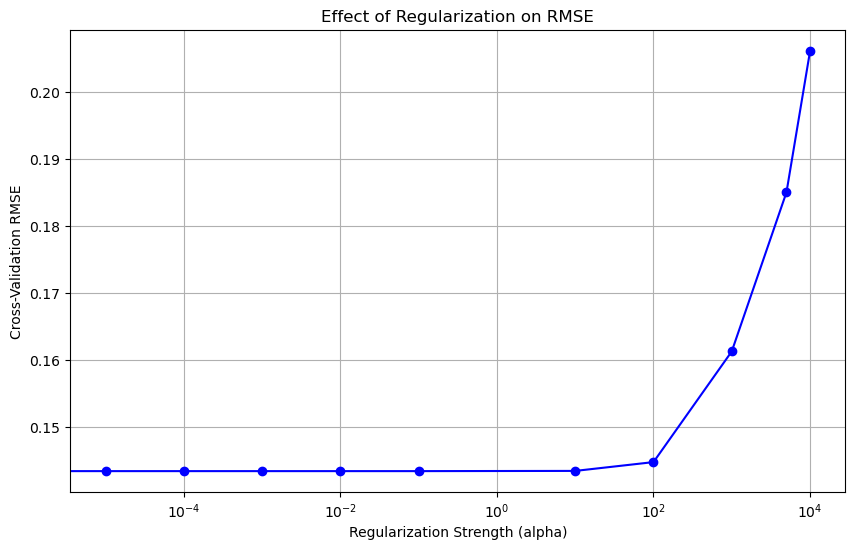

In [5]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(reg_values, rmse_values, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Regularization Strength (alpha)')
plt.ylabel('Cross-Validation RMSE')
plt.title('Effect of Regularization on RMSE')
plt.grid(True)
plt.show()    


# Feature selection:

Backwards selection

In [7]:
from sklearn.feature_selection import SequentialFeatureSelector

# Backward selection: Start with all features and remove one at a time
backward_selector = SequentialFeatureSelector(
    Ridge(alpha=opt_reg),  # model with optimal reg.
    n_features_to_select="auto",
    direction="backward", 
    cv=10, 
    scoring="neg_root_mean_squared_error"
)
backward_selector.fit(X_train, Y_train)

# Get selected feature indices
selected_backward_features = backward_selector.get_support(indices=True)
print(f"Selected Features (Backward): {selected_backward_features}")


X_train_backward = X_train[:, selected_backward_features]

# backward model evaluate
backward_score = cross_val_score(Ridge(alpha=opt_reg), X_train_backward, Y_train, cv=10, scoring="neg_root_mean_squared_error")

print("Backward score:", -backward_score.mean())


Selected Features (Backward): [0 1 2 5 8]
Backward score: 0.14343409206956662


Forward Selection:

In [8]:
# Forward selection: Start with no features and add one at a time
forward_selector = SequentialFeatureSelector(
    Ridge(alpha=opt_reg),  # model with optimal reg.
    n_features_to_select="auto",
    direction="forward", 
    cv=10, 
    scoring="neg_root_mean_squared_error"
)
forward_selector.fit(X_train, Y_train)

# Get selected feature indices
selected_forward_features = forward_selector.get_support(indices=True)
print(f"Selected Features (Forward): {selected_forward_features}")

X_train_forward = X_train[:, selected_forward_features]

# Forward model evaluation
forward_score = cross_val_score(Ridge(alpha=opt_reg), X_train_forward, Y_train, cv=10, scoring="neg_root_mean_squared_error")

print("Forward score:", -forward_score.mean())


Selected Features (Forward): [0 1 2 8]
Forward score: 0.14352236951954928


# Final model

In [ ]:
# Train forward model
model_forward = Ridge(alpha=opt_reg)
model_forward.fit(X_train_forward, Y_train)
# Predict and calculate RMSE for forward model
y_pred_forward = model_forward.predict(X_test[:, selected_forward_features])
test_rmse_forward = np.sqrt(mean_squared_error(Y_test, y_pred_forward))

# Train backward model
model_backward = Ridge(alpha=opt_reg)
model_backward.fit(X_train_backward, Y_train)
# Predict and calculate RMSE for backward model
y_pred_backward = model_backward.predict(X_test[:, selected_backward_features])
test_rmse_backward = np.sqrt(mean_squared_error(Y_test, y_pred_backward))


# Calculate R^2 values
r2_all_features = model.score(X_test, Y_test)
r2_forward = model_forward.score(X_test[:, selected_forward_features], Y_test)
r2_backward = model_backward.score(X_test[:, selected_backward_features], Y_test)

# Print R^2 values
print(f"R^2 All features          : {r2_all_features:.8f}")
print(f"R^2 Forward model         : {r2_forward:.8f}")
print(f"R^2 Backward model        : {r2_backward:.8f}")

# Print results
print(f"\nTest RMSE All features          : {test_rmse_all_features:.8f}")
print(f"Test RMSE Forward model         : {test_rmse_forward:.8f}")
print(f"Test RMSE Backward model        : {test_rmse_backward:.8f}")





R^2 All features          : 0.97820559
R^2 Forward model         : 0.97821174
R^2 Backward model        : 0.97820147

Test RMSE All features          : 0.14662990
Test RMSE Forward model         : 0.14660922
Test RMSE Backward model        : 0.14664375

Forward Model Feature Weights:
Feature: cut        Weight: 0.03354031
Feature: color      Weight: 0.13092502
Feature: clarity    Weight: 0.19843262
Feature: depth      Weight: -0.00458620
Feature: table      Weight: -0.00051295
Feature: x          Weight: 0.01851603
Feature: z          Weight: 0.00538536
Feature: y          Weight: 0.00548592
Feature: log_carat  Weight: 1.05295584

Forward Model Feature Weights:
Feature: cut        Weight: 0.03527469
Feature: color      Weight: 0.13079189
Feature: clarity    Weight: 0.19883028
Feature: log_carat  Weight: 1.08193364

Backward Model Feature Weights:
Feature: cut        Weight: 0.03437151
Feature: color      Weight: 0.13125782
Feature: clarity    Weight: 0.19861590
Feature: x          Weig

In [13]:
print("\nForward Model Feature Weights:")
# print feature weight for all features model
weights = model.coef_
for name, weight in zip(feature_names, weights):
    print(f"Feature: {name:<10} Weight: {weight:.8f}")


# Print feature weights for forward model
print("\nForward Model Feature Weights:")
forward_weights = model_forward.coef_
for name, weight in zip(feature_names[selected_forward_features], forward_weights):
    print(f"Feature: {name:<10} Weight: {weight:.8f}")

# Print feature weights for backward model
print("\nBackward Model Feature Weights:")
backward_weights = model_backward.coef_
for name, weight in zip(feature_names[selected_backward_features], backward_weights):
    print(f"Feature: {name:<10} Weight: {weight:.8f}")


Forward Model Feature Weights:
Feature: cut        Weight: 0.03354031
Feature: color      Weight: 0.13092502
Feature: clarity    Weight: 0.19843262
Feature: depth      Weight: -0.00458620
Feature: table      Weight: -0.00051295
Feature: x          Weight: 0.01851603
Feature: z          Weight: 0.00538536
Feature: y          Weight: 0.00548592
Feature: log_carat  Weight: 1.05295584

Forward Model Feature Weights:
Feature: cut        Weight: 0.03527469
Feature: color      Weight: 0.13079189
Feature: clarity    Weight: 0.19883028
Feature: log_carat  Weight: 1.08193364

Backward Model Feature Weights:
Feature: cut        Weight: 0.03437151
Feature: color      Weight: 0.13125782
Feature: clarity    Weight: 0.19861590
Feature: x          Weight: 0.03819616
Feature: log_carat  Weight: 1.04401665
